# Load data and check them
The goal of this notebook is to load data anche check if they are consistent.

In [11]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Import dependencies

(to check, a lot of unnecessary imports)

In [12]:
import os
from multiprocessing import Pool, cpu_count

import numpy as np
from scipy import fft
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import tqdm

import torch
import torchvision.transforms as transforms

from functions.utils import save_as_npz, pltdataset, read_arr
#from functions.data_loader import *

## Read data

The data are stored in folders under the directory `../data`, in particular each folder contains several .dat files as follow:
```
├── dataL14
│   ├── evalues.dat
│   ├── speckleF.dat
│   └── speckleR.dat
├── dataL28
│   ├── evalues.dat
│   ├── speckleF.dat
│   └── speckleR.dat
└── ...
```
Each folder contains different data, both for shape and size. One has to handle this during reading. Once one has read the file they are saved as numpy standard format to speed up trainig, since in previous tests dataloading seems to be a bottleneck.

The following script load and save data in a dictionary-like file with the same name of the original folder, splitting trainig and test dataset (splitting between train and valuation set is performed on the fly during the training), with a 80:20 ratio.


In [3]:
data_path = "../data"

for path in tqdm.tqdm(os.listdir(data_path)):
    if path[-2:] == '28':
        data_size = 512
    elif path[-2:] == '56':
        data_size = 1024
    else:
        data_size = 256
        continue
    full_path = os.path.join(data_path, path)
    save_as_npz(full_path, data_size, seed=0, test_size=0.2)

100%|██████████| 4/4 [10:29<00:00, 157.41s/it]


Data are now organized as follow:
```
├── train_dataL14.npz
├── test_dataL14.npz
├── train_dataL28.npz
├── test_dataL28.npz
└── ...
```
Where each file as the following numpy arrays `['evalues', 'speckleR', 'speckleF', 'x_axis', 'csi_axis']`. All the array are real except `speckleF`, which is complex.
Note that the sum of occurrence in the dataset is 150000, as we expected for `dataL14` files.

In [13]:
train_data = np.load('train_data_L14.npz')
test_data = np.load('test_data_L14.npz')

print('Arrays in training dataset {} with the following dtype and shape:\n'.format(train_data.files))

for key in train_data.files:
    print('{0} with type {1} and shape {2}'.format(key, train_data[key].dtype, train_data[key].shape))

print('\n\nArrays in test dataset {} with the following dtype and shape:\n'.format(test_data.files))

for key in test_data.files:
    print('{0} with type {1} and shape {2}'.format(key, test_data[key].dtype, test_data[key].shape)) 


Arrays in training dataset ['evalues', 'speckleR', 'speckleF', 'x_axis', 'csi_axis'] with the following dtype and shape:

evalues with type float64 and shape (150000,)
speckleR with type float64 and shape (150000, 256)
speckleF with type complex128 and shape (150000, 256)
x_axis with type float64 and shape (150000, 256)
csi_axis with type float64 and shape (150000, 256)


Arrays in test dataset ['evalues', 'speckleR', 'speckleF', 'x_axis', 'csi_axis'] with the following dtype and shape:

evalues with type float64 and shape (0,)
speckleR with type float64 and shape (0, 256)
speckleF with type complex128 and shape (0, 256)
x_axis with type float64 and shape (0, 256)
csi_axis with type float64 and shape (0, 256)


## Check imported data

Lets briefly analize our dataset, in particular we look at their consistence, performing [torch.fft.fft](https://pytorch.org/docs/stable/generated/orch.fft.html#torch-fft) (Fast Fourier Trasform) to the `speckleR` and comparing with the `speckleF`.

difference beetween given fourier data and computed fourier data (real) tensor(0.0075, dtype=torch.float64)
difference beetween given fourier data and computed fourier data (imaginary) tensor(0.0074, dtype=torch.float64)


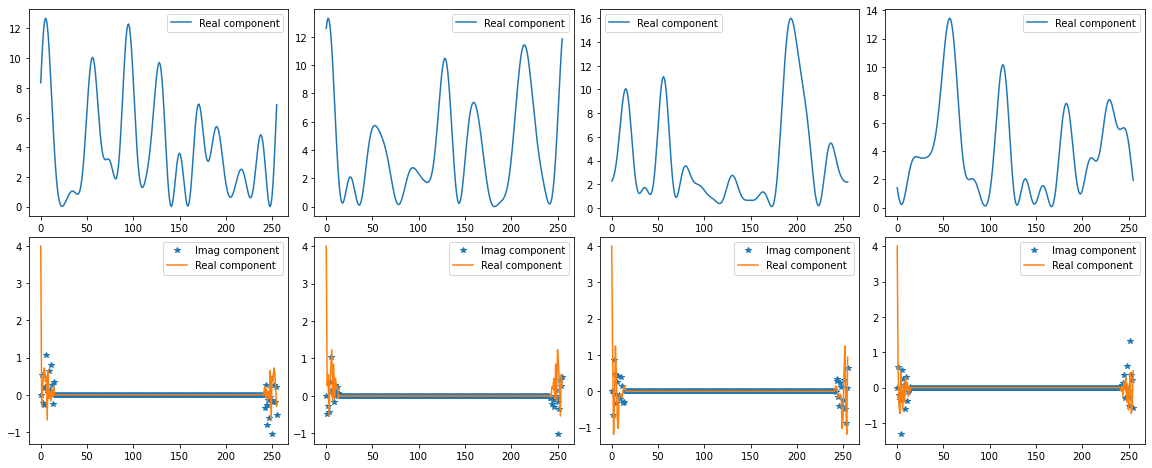

In [18]:
import torch.fft


speckleR = torch.from_numpy(train_data['speckleR'])
speckleF = torch.from_numpy(train_data['speckleF'])

speckle_fou = torch.fft.fft(speckleR, dim=1, norm='forward')
speckle_rfou = torch.fft.rfft(speckleR, dim=1, norm='forward')

print('difference beetween given fourier data and computed fourier data (real)', torch.mean(torch.sum(((speckleF.real - speckle_fou.real).abs()), dim=1)))
print('difference beetween given fourier data and computed fourier data (imaginary)', torch.mean(torch.sum(((speckleF.imag + speckle_fou.imag).abs()), dim=1)))

keys = ['speckleR', 'speckleF']
pltdataset(4, train_data, keys=keys)



Due a different definition of FFT beetween numpy/pytorch and the original data we have
$$ F[V_x](\xi) = -V_{\xi},$$
where $V_x$ is the potential in the real field, while $V_{\xi}$ is that one in the Fourier space. Here the plot of the original signal in Fourier and the one obtainedusing [Pytorch definition](https://pytorch.org/docs/stable/generated/torch.fft.html#torch-fft).

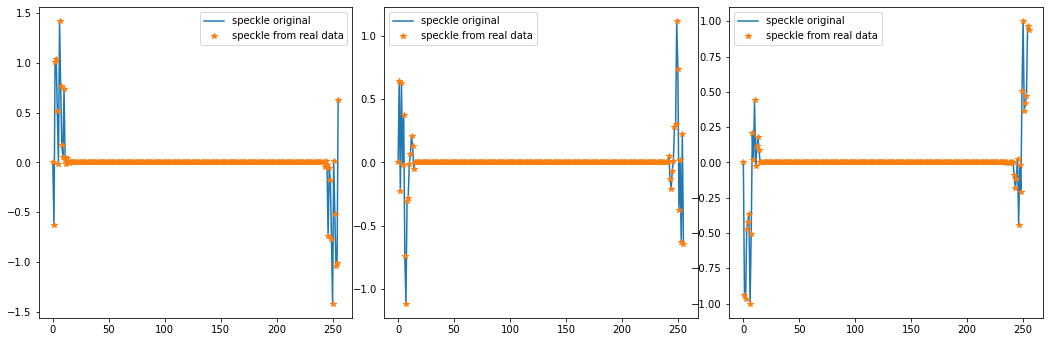

In [17]:
    rows = 2
    plt_num = 3

    fig = plt.figure(figsize=(6 * plt_num, 6*rows))
    fig.subplots_adjust(hspace=0.1, wspace=0.1)
    for num, image in enumerate(speckleF[:plt_num, :]):
        ax = fig.add_subplot(rows, plt_num, num + 1)
        ax.plot(-image.imag, '-', label='speckle original (imag part)')
        ax.plot(speckle_fou[num, :].imag, '*', label='speckle from real data (imag part)')
        plt.legend()

So, in order to be self consistent, one needs to apply the Pytorch's fft with normalization. As shown in plot and in the computed mean-difference beetween the original data and the transformation of the `speckleF`.

Difference beetween given real data and computed inverse of fourier data (real) tensor(0.0966, dtype=torch.float64)


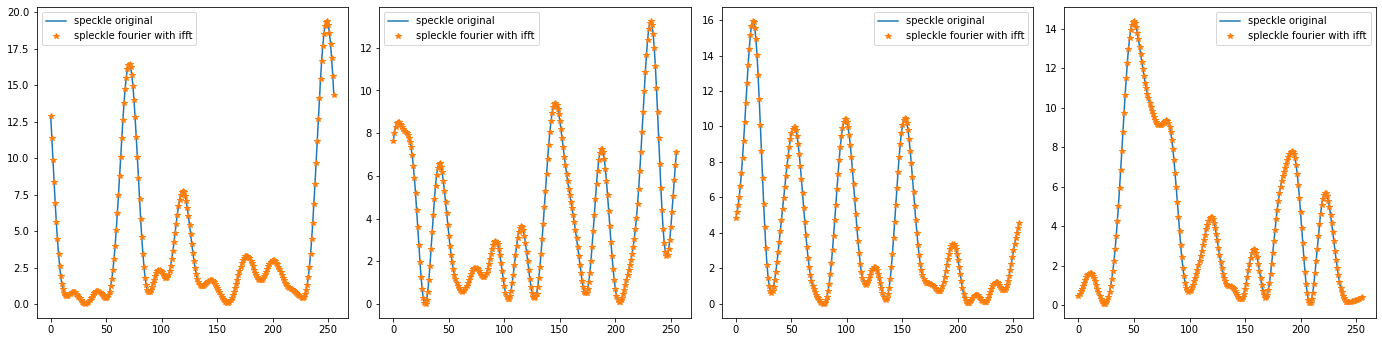

In [27]:
t = torch.fft.fft(speckleF,  dim=1, norm='backward')

print('Difference beetween given real data and computed inverse of fourier data (real)', torch.mean(torch.sum(((speckleR - t).abs()), dim=1)))

rows = 2
plt_num = 4

fig = plt.figure(figsize=(6 * plt_num, 6*rows))
fig.subplots_adjust(hspace=0.1, wspace=0.1)
for num, image in enumerate(speckleR[:plt_num, :]):
    ax = fig.add_subplot(rows, plt_num, num + 1)
    ax.plot(image, '-', label='speckle original')
    ax.plot(t[num], '*', label='spleckle fourier with ifft')
    plt.legend()


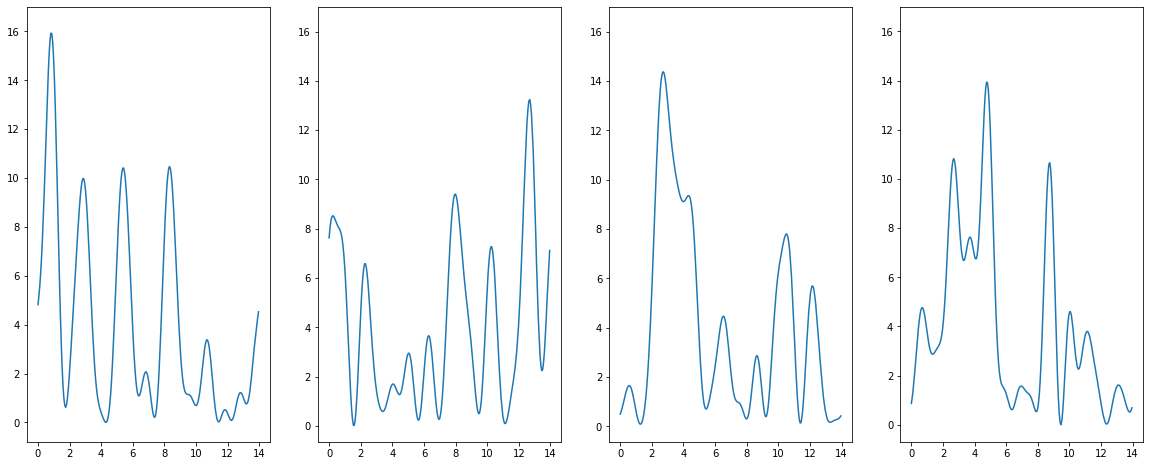

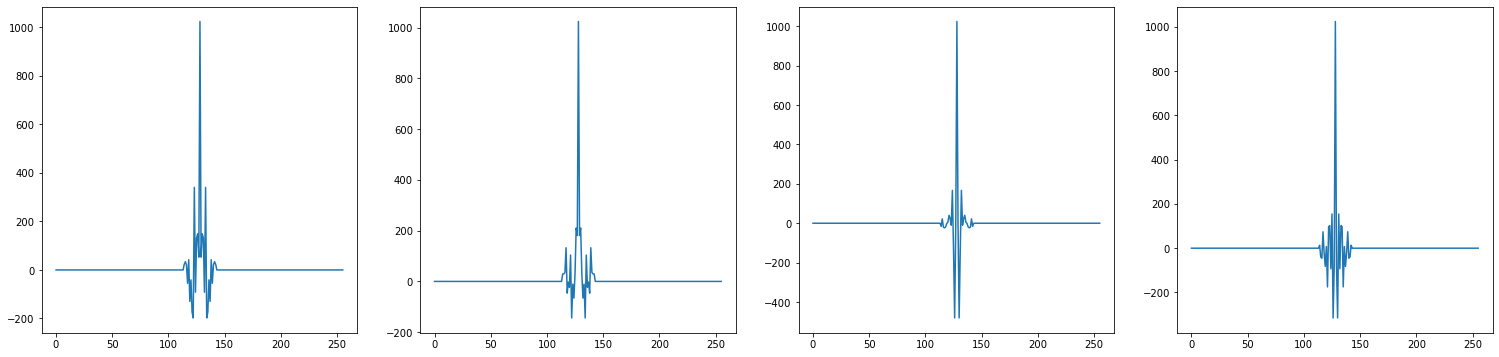

In [28]:
speckle_real = data['speckle_r']
speckle_fou = data['speckle_f']
x_axis = data['x_axis']

fig, (ax1,ax2,ax3,ax4) = plt.subplots(1,4, figsize=(20,8))
ax1.plot(x_axis, speckle_real[2])
ax1.set_ylim(top=17)
ax2.plot(x_axis, speckle_real[1])
ax2.set_ylim(top=17)
ax3.plot(x_axis, speckle_real[3])
ax3.set_ylim(top=17)
ax4.plot(x_axis, speckle_real[4])
ax4.set_ylim(top=17)

fig, (ax1,ax2,ax3,ax4) = plt.subplots(1,4, figsize=(26,6))
ax1.plot(fft.fftshift(fft.fft(speckle_real[2])))
#ax1.set_ylim(top=17)
ax2.plot(fft.fftshift(fft.fft(speckle_real[1])))
#ax2.set_ylim(top=17)
ax3.plot(fft.fftshift(fft.fft(speckle_real[3])))
#ax3.set_ylim(top=17)
ax4.plot(fft.fftshift(fft.fft(speckle_real[4])))
#ax4.set_ylim(top=17)
plt.show()

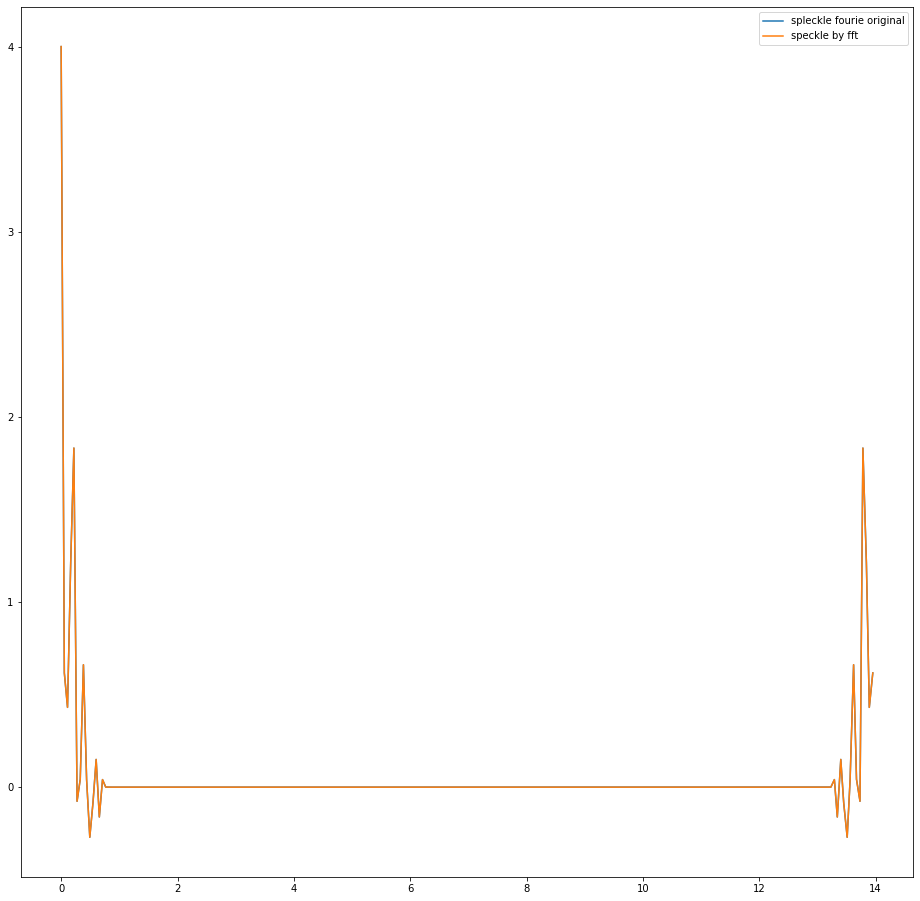

In [58]:
fig = plt.figure(figsize=(16,16))
plt.plot(x_axis, speckle_fou[0], label="spleckle fourie original")
plt.plot(x_axis, fft.fft(speckle_real[0])/256, label="speckle by fft")
plt.legend()
plt.show()